In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from transformers import ViTForImageClassification
import numpy as np

import sys; sys.path.append("../src/")
from models import SmoothMaskedImageClassifier
from data_utils import load_images_from_directory
from stability import soft_stability_rate

torch.manual_seed(1234)
device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
run_stuff = True
overwrite_cache = True

In [3]:
images = load_images_from_directory("/home/antonxue/foo/imagenet-sample-images").to(device)
print(images.shape)

torch.Size([1000, 3, 224, 224])


In [4]:
idxs = torch.randperm(len(images))[:50]
images = images[idxs]
print(images.shape)

torch.Size([50, 3, 224, 224])


In [5]:
plus_r = 20
lambdas = [1.0, 0.8, 0.6]
alpha_sizes = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120]

In [6]:
stability_rates = []

In [7]:
if run_stuff:
    for lambda_ in lambdas:
        smooth_model = SmoothMaskedImageClassifier(
            torchvision.models.resnet18(
                weights = torchvision.models.ResNet18_Weights.IMAGENET1K_V1
            ),
            num_samples = 32,
            lambda_ = lambda_
        ).eval().to(device)

        with torch.no_grad():
            lambda_rates = []
            pbar = tqdm(alpha_sizes)
            for asize in pbar:
                accum = 0
                for img in images:
                    hot_bits = torch.randperm(196)[:asize]
                    alpha = torch.nn.functional.one_hot(hot_bits, 196).sum(dim=0).to(device)
                    accum += soft_stability_rate(smooth_model, img, alpha, plus_r).item()
                lambda_rates.append(accum / len(images))
                pbar.set_description(
                    f"lambda {lambda_:.2f}, asize {asize}, stab rate {lambda_rates[-1]:.3f}"
                )
            stability_rates.append(np.array(lambda_rates))

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

In [8]:
if overwrite_cache and len(stability_rates) > 0:
    torch.save(
        {"lambdas":lambdas, "stability_rates":stability_rates},
        f"_cache/resnet18_plusr{plus_r}_stability_vs_asize.pt"
    )

<Figure size 640x480 with 0 Axes>

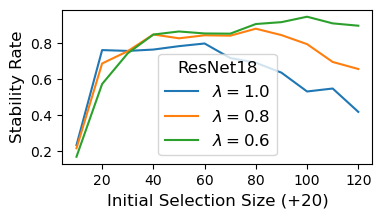

In [9]:
fs = 12
plt.clf()
fig, ax = plt.subplots(figsize=(4,2))

for i, lam in enumerate(lambdas):
    ax.plot(alpha_sizes, stability_rates[i], label=f"$\lambda = {lam:.1f}$")

ax.set_ylabel("Stability Rate", fontsize=fs)
ax.set_xlabel(f"Initial Selection Size (+{plus_r})", fontsize=fs)

ax.set_xticks(alpha_sizes[::-2])
ax.tick_params(axis="both", labelsize=fs-2)

ax.legend(title="ResNet18", loc="lower center", title_fontsize=fs, fontsize=fs)
plt.savefig(f"../figures/resnet18_plusr{plus_r}_stability_vs_asize.pdf", bbox_inches="tight")